In [1]:
import pandas as pd
from src.helper import get_split_data

In [2]:
X_trn, y_trn, X_val, y_val, X_tst, y_tst = get_split_data.split_data_for_training(4)

X = pd.concat([X_trn, X_val], axis='index')
y = pd.Series([*y_trn, *y_val], index=X.index)

In [3]:
from sklearn.metrics import precision_score
import xgboost as xgb

params = {'colsample_bytree': 0.9077026244052322,
              'gamma': 3.005390622000065,
              'learning_rate': 0.27925755425968624,
              'max_depth': 10,
              'n_estimators': 550,
              'reg_alpha': 0.26498100920063794,
              'reg_lambda': 0.002326481936386609,
              'subsample': 0.8799923291489485}

model = xgb.XGBClassifier(
    **params,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",

)

model.fit(X_trn, y_trn, eval_set=[(X_trn, y_trn), (X_val, y_val)], verbose=False)

y_pred_proba = model.predict_proba(X_tst)

custom_threshold = 0.5
y_pred = (y_pred_proba[:, 1] > custom_threshold).astype(int)

print(y_pred)

precision = precision_score(y_tst, y_pred, average="binary", zero_division=1)
precision

[0 0 0 0 1 0 1 1 0 0]


np.float64(0.0)

In [4]:
import shap

shap.initjs()
shap_ex = shap.TreeExplainer(model)
vals = shap_ex(X_tst)

shap_df = pd.DataFrame(vals.values, columns=X_tst.columns)
print(shap_df)

   points_home  points_away  home_last_team_goal  home_last_team_shoton  \
0    -0.011035    -0.106662             0.003195              -0.060798   
1     0.007737    -0.031392             0.008243              -0.092593   
2     0.035115     0.026960            -0.001939              -0.067881   
3     0.013773     0.001750            -0.014281               0.220693   
4     0.009037     0.103127            -0.013757              -0.080237   
5     0.039849     0.029179            -0.011633               0.331619   
6    -0.022078    -0.000085             0.006694              -0.040031   
7     0.020474    -0.009220            -0.003828              -0.102693   
8     0.029529     0.007331            -0.016616               0.011131   
9     0.023958    -0.052444             0.006974               0.021339   

   home_last_team_possession  away_last_team_goal  away_last_team_shoton  \
0                   0.033309             0.006235               0.034588   
1                   0.

In [9]:
import numpy as np

print(pd.concat([shap_df.sum(axis='columns').rename('pred') + vals.base_values,
                 pd.Series(y_pred, name='predicted values'),
                 pd.Series(y_tst, name='true values')], axis='columns')
      .assign(prob=lambda adf: (np.exp(adf.pred) / (1 + np.exp(adf.pred))))
      )

       pred  predicted values  true values      prob
0 -1.222208                 0            0  0.227548
1 -1.465806                 0            0  0.187581
2 -0.148879                 0            0  0.462849
3 -0.932702                 0            0  0.282377
4  0.712854                 1            0  0.671031
5 -0.791935                 0            1  0.311753
6  1.098326                 1            0  0.749946
7  1.260181                 1            0  0.779057
8 -1.011567                 0            1  0.266673
9 -1.661082                 0            1  0.159617


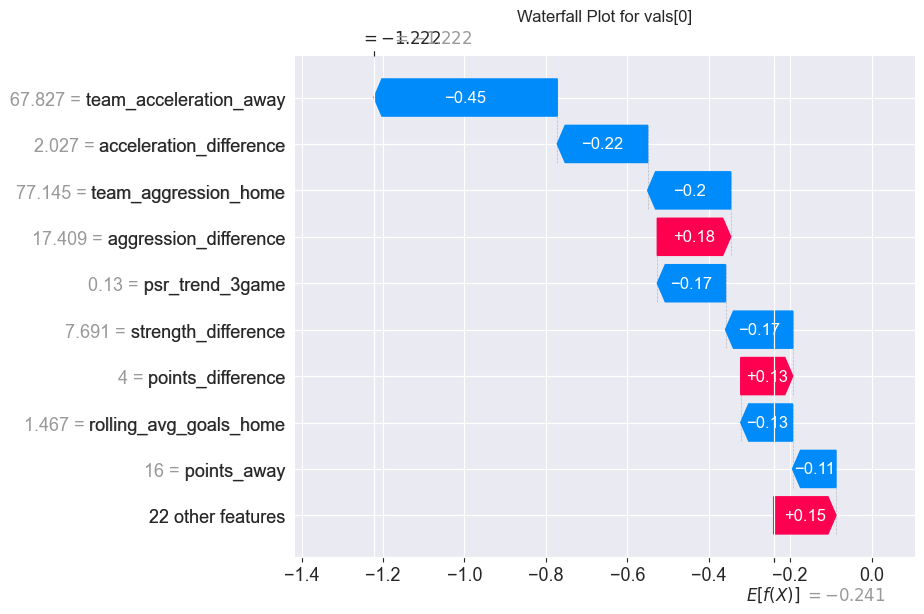

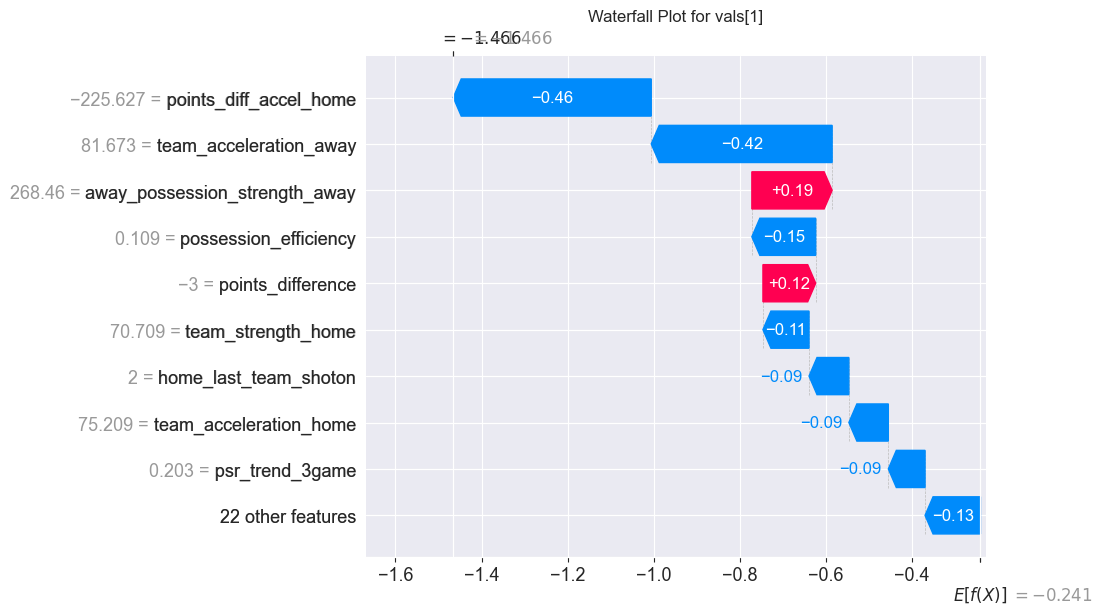

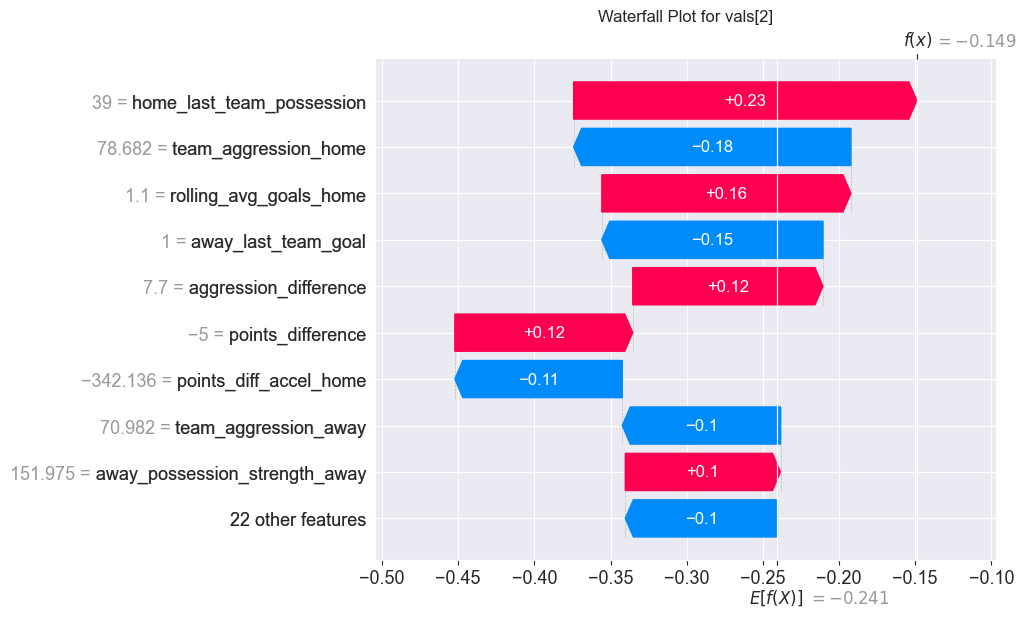

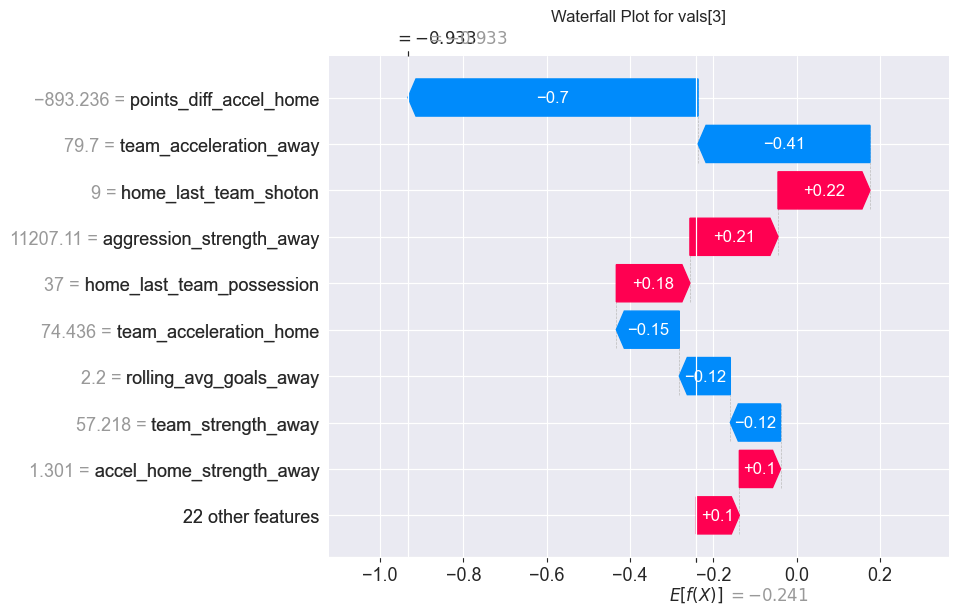

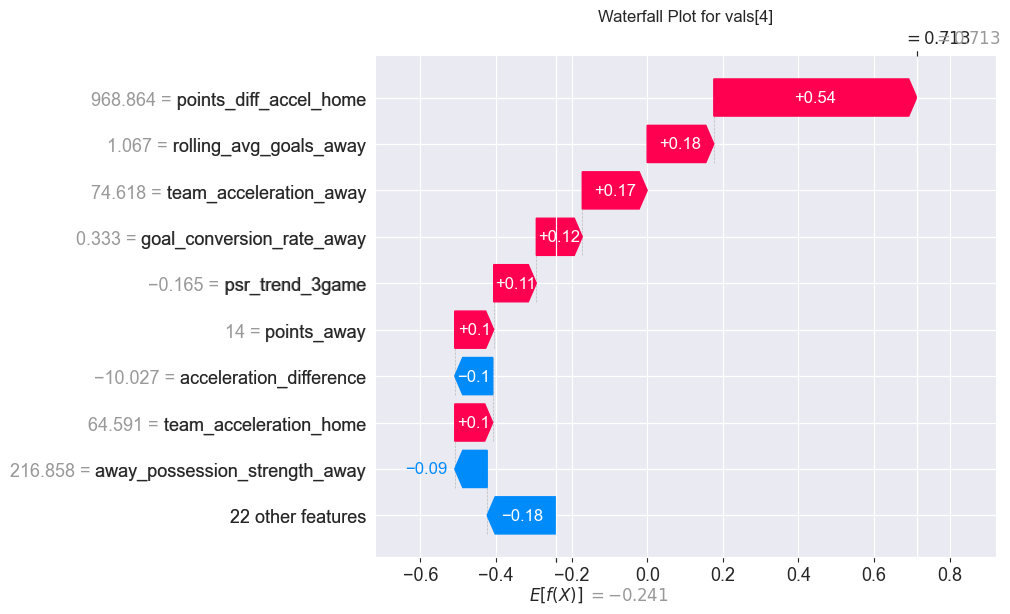

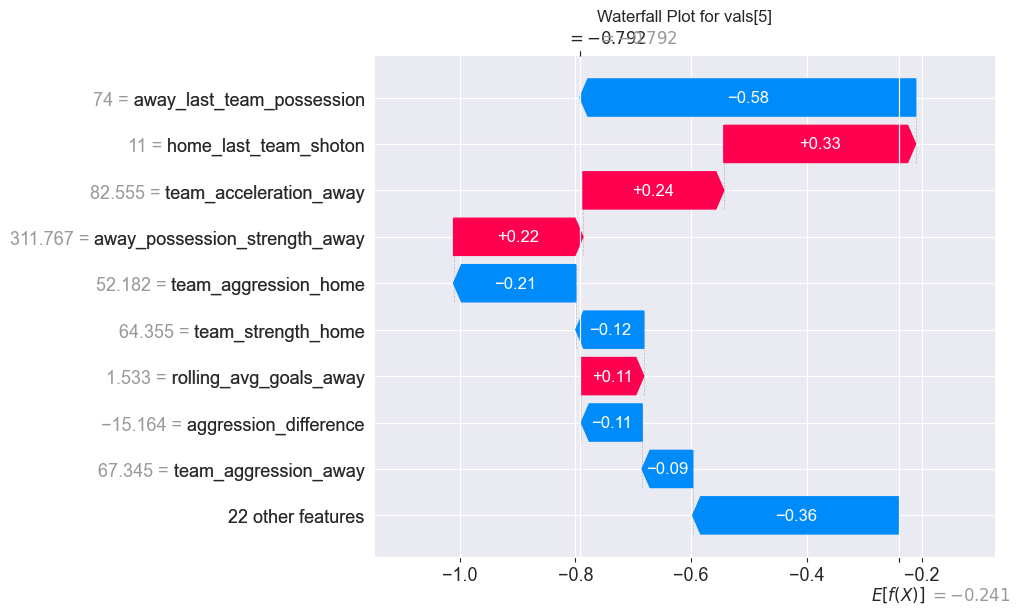

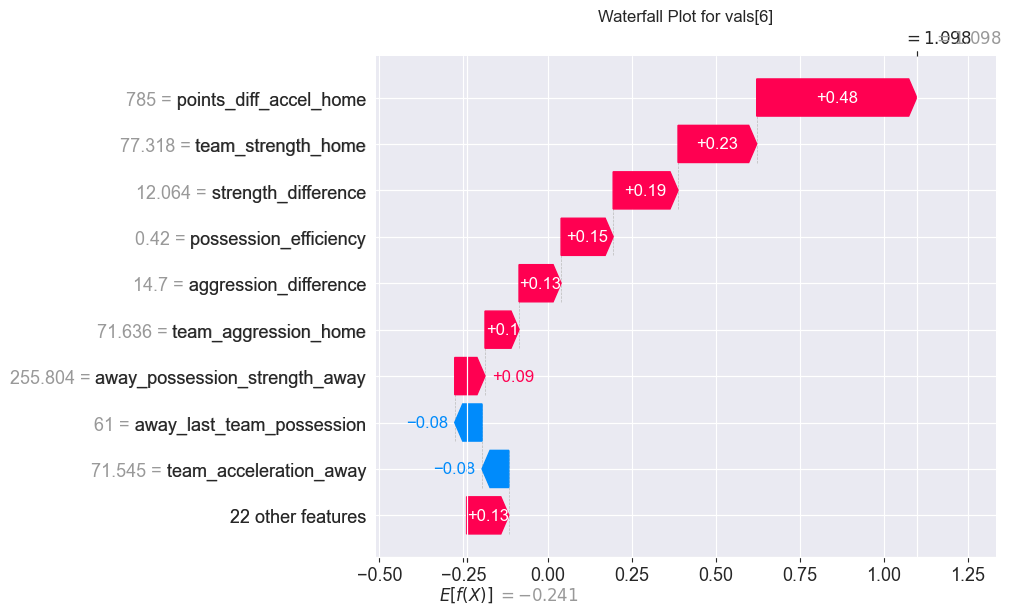

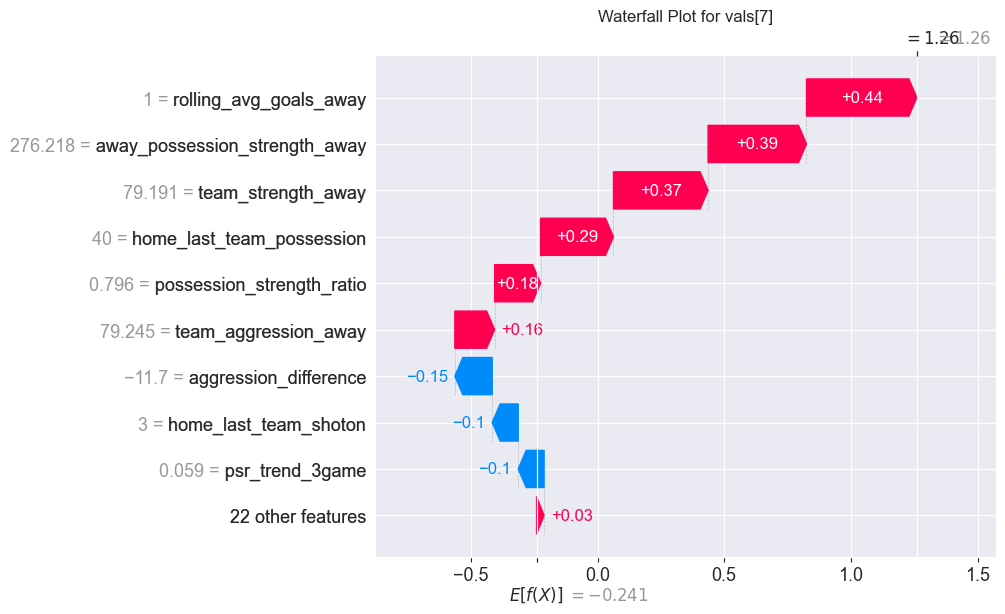

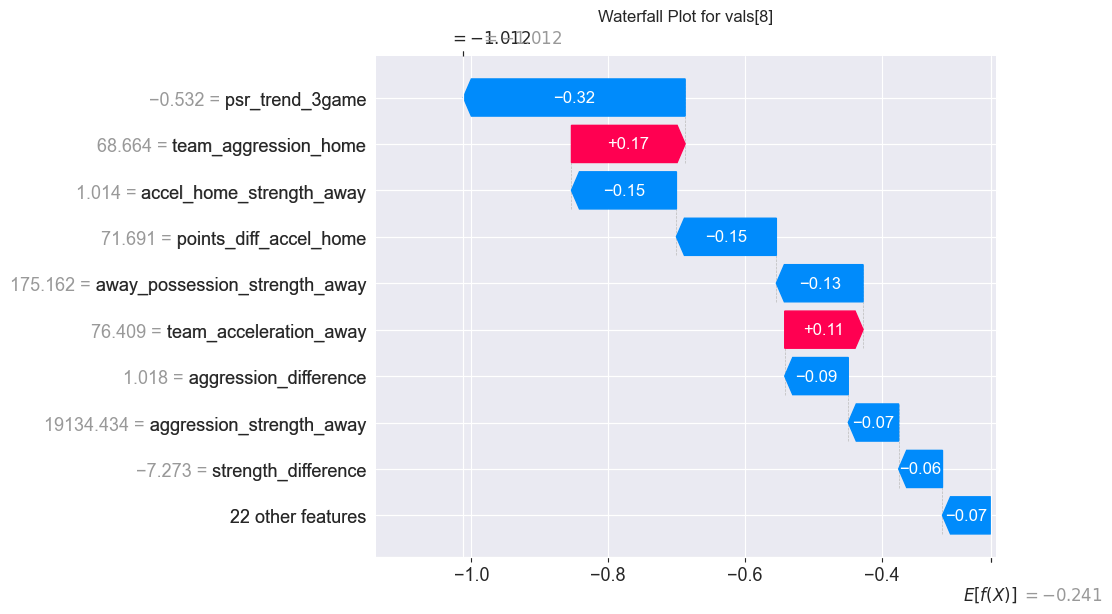

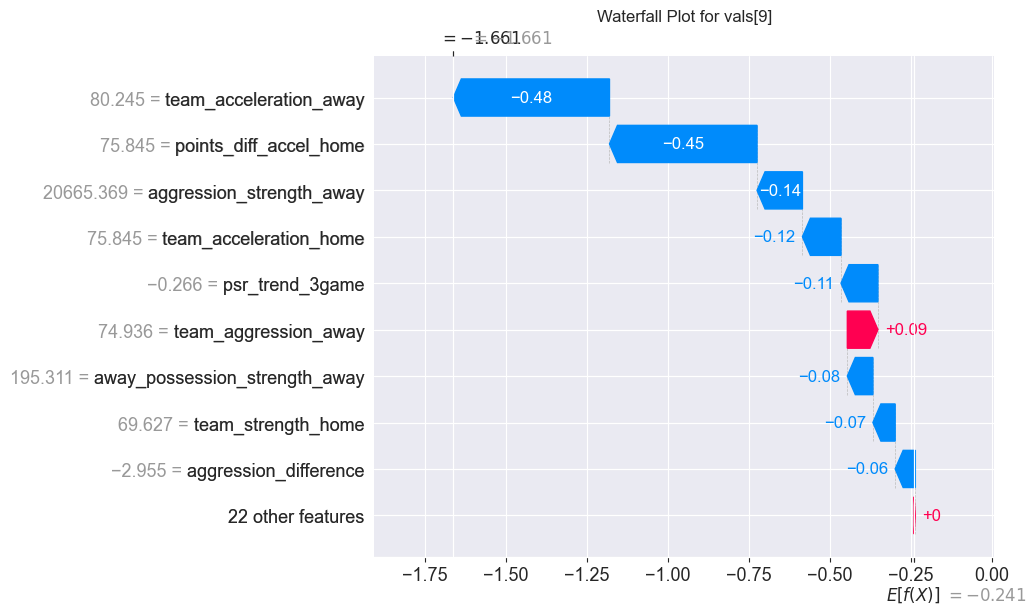

In [6]:
from matplotlib import pyplot as plt

for i, val in enumerate(vals):
    fig = plt.figure(figsize=(8, 4))
    shap.plots.waterfall(val, show=False)
    plt.title(f"Waterfall Plot for vals[{i}]")
    plt.show()

In [7]:
def plot_histograms(df, columns, row=None, title='', color='shap'):
    """
    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame to plot histograms for.
    columns : list of str
        The names of the columns to plot histograms for.
    row : pandas.Series, optional
        A row of data to plot a vertical line for.
    title : str, optional
        The title to use for the figure.
    color : str, optional
        'shap' - color positive values red. Negative blue
        'mean' - above mean red. Below blue.
        None - black
    Returns
    -------
    matplotlib.figure.Figure
        The figure object containing the histogram plots.
    """
    red = '#ff0051'
    blue = '#008bfb'

    fig, ax = plt.subplots(figsize=(15, 10))
    hist = (df[columns].hist(ax=ax, color='#bbb'))
    fig = hist[0][0].get_figure()

    if row is not None:
        name2ax = {ax.get_title(): ax for ax in fig.axes}
        pos, neg = red, blue
        if color is None:
            pos, neg = 'black', 'black'
        for column in columns:
            if color == 'mean':
                mid = df[column].mean()
            else:
                mid = 0
            if row[column] > mid:
                c = pos
            else:
                c = neg
            name2ax[column].axvline(row[column], c=c)
    fig.tight_layout()
    fig.suptitle(title)
    return fig

In [8]:
features = ['team_aggression_home', 'team_acceleration_away', 'aggression_difference', 'points_diff_accel_home', 'momentum_multiplier', 'away_last_team_goal']
fig = plot_histograms(shap_df, features, shap_df.iloc[0], title='SHAP values for row 0')
plt.show()

KeyError: "['momentum_multiplier'] not in index"

/tmp/ipykernel_352572/1672211698.py:26: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  hist = (df[columns].hist(ax=ax, color='#bbb'))


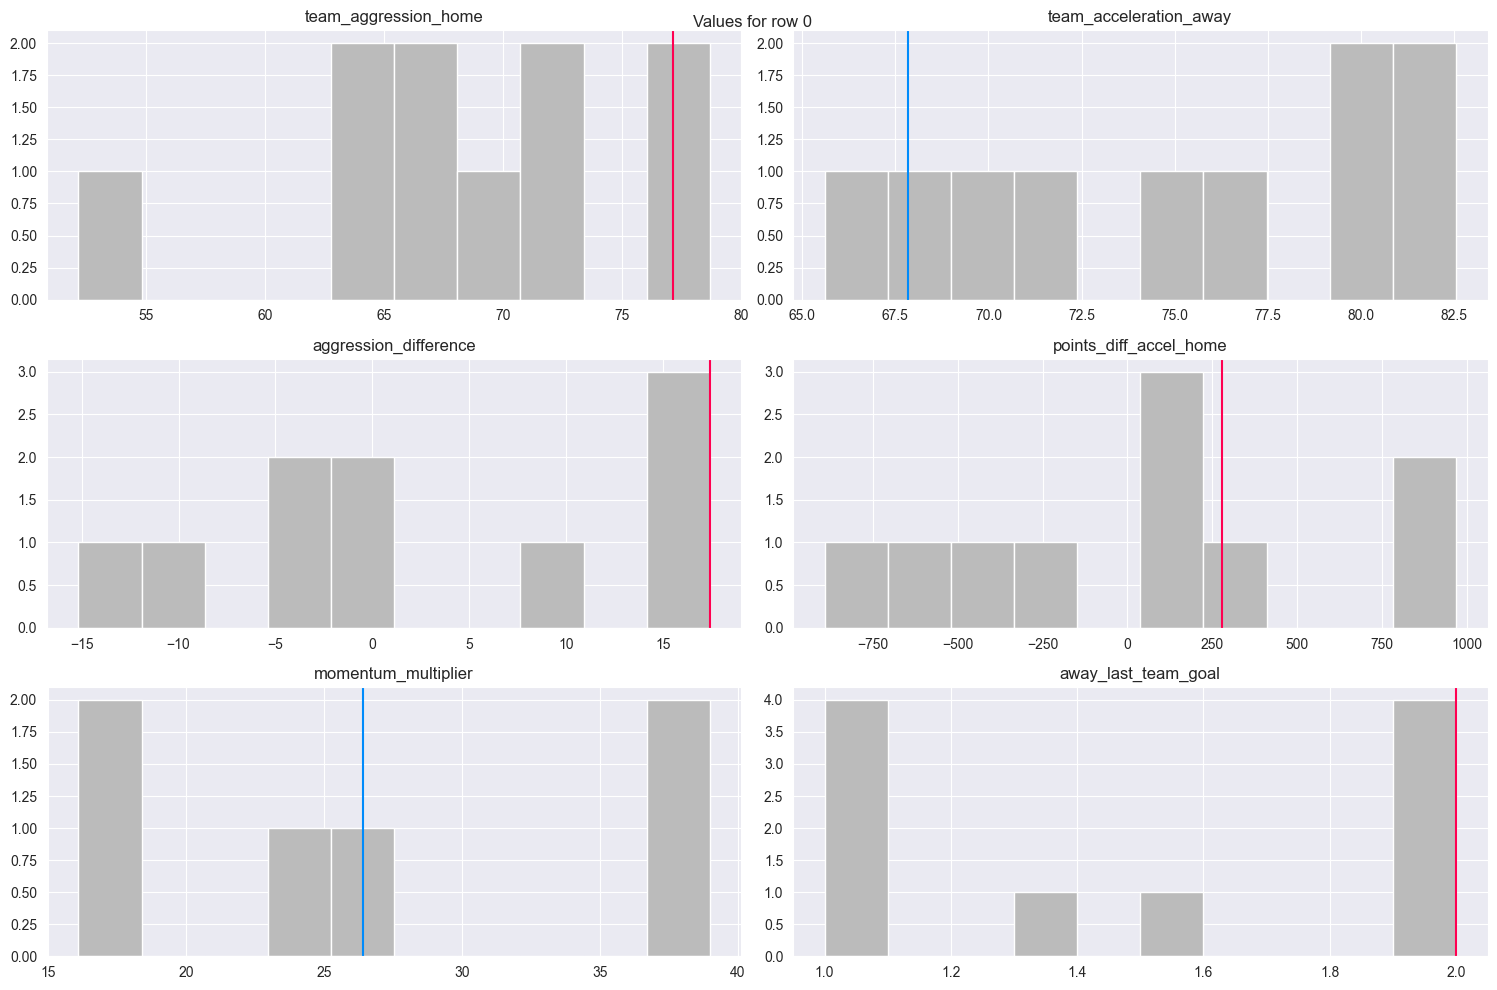

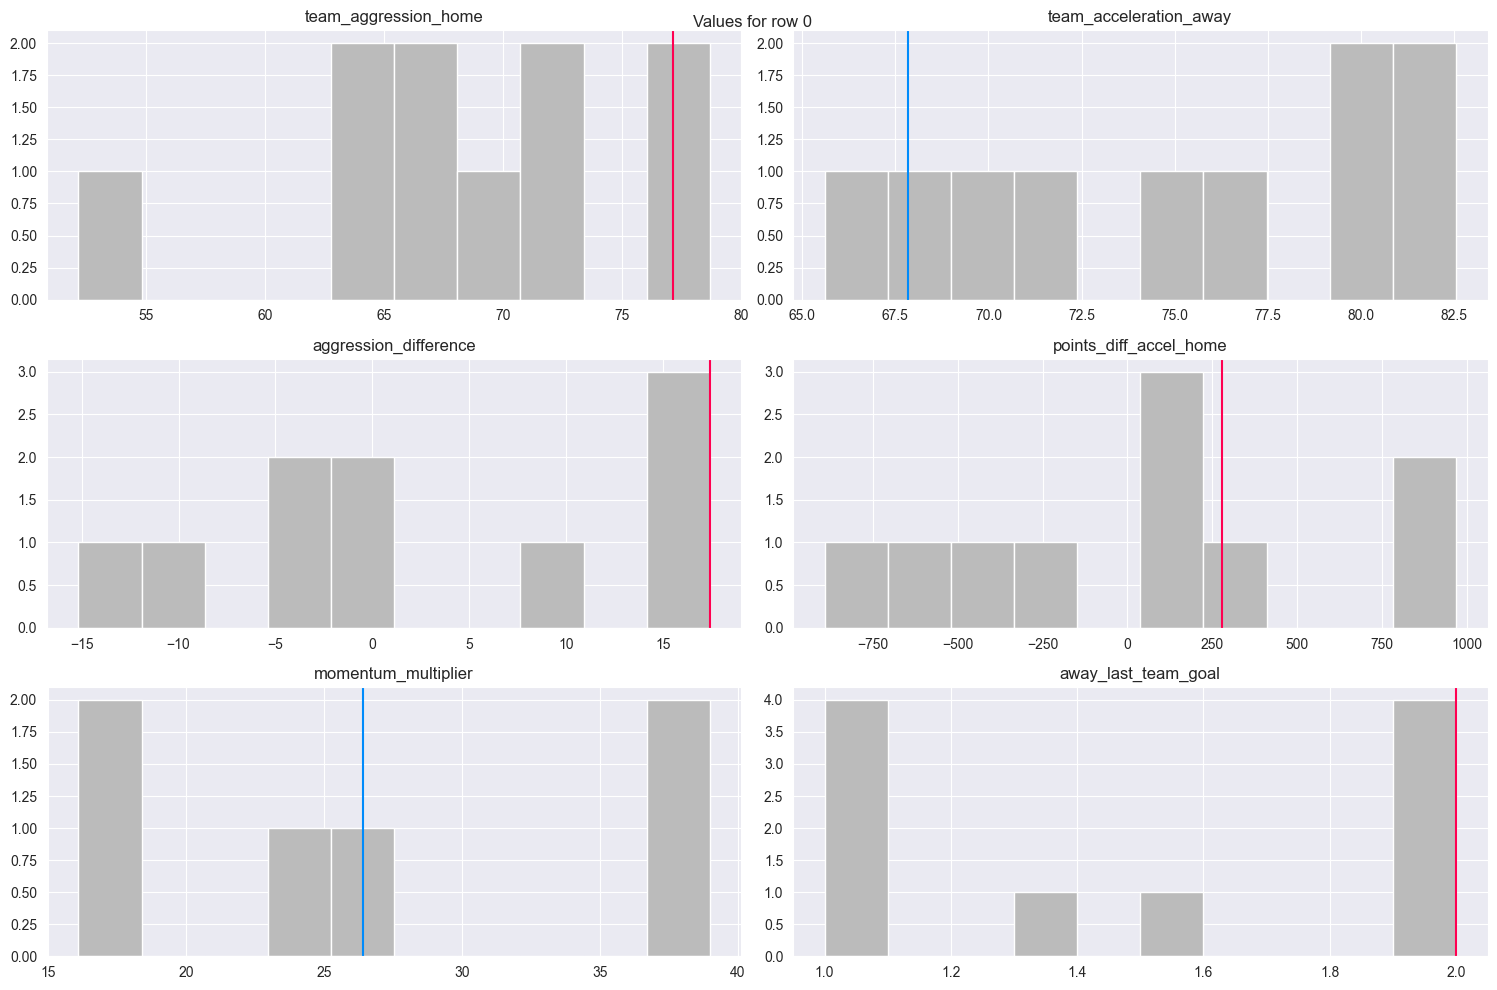

In [76]:
fig = plot_histograms(X_tst, features, X_tst.iloc[0], title='Values for row 0', color='mean')
plt.show()

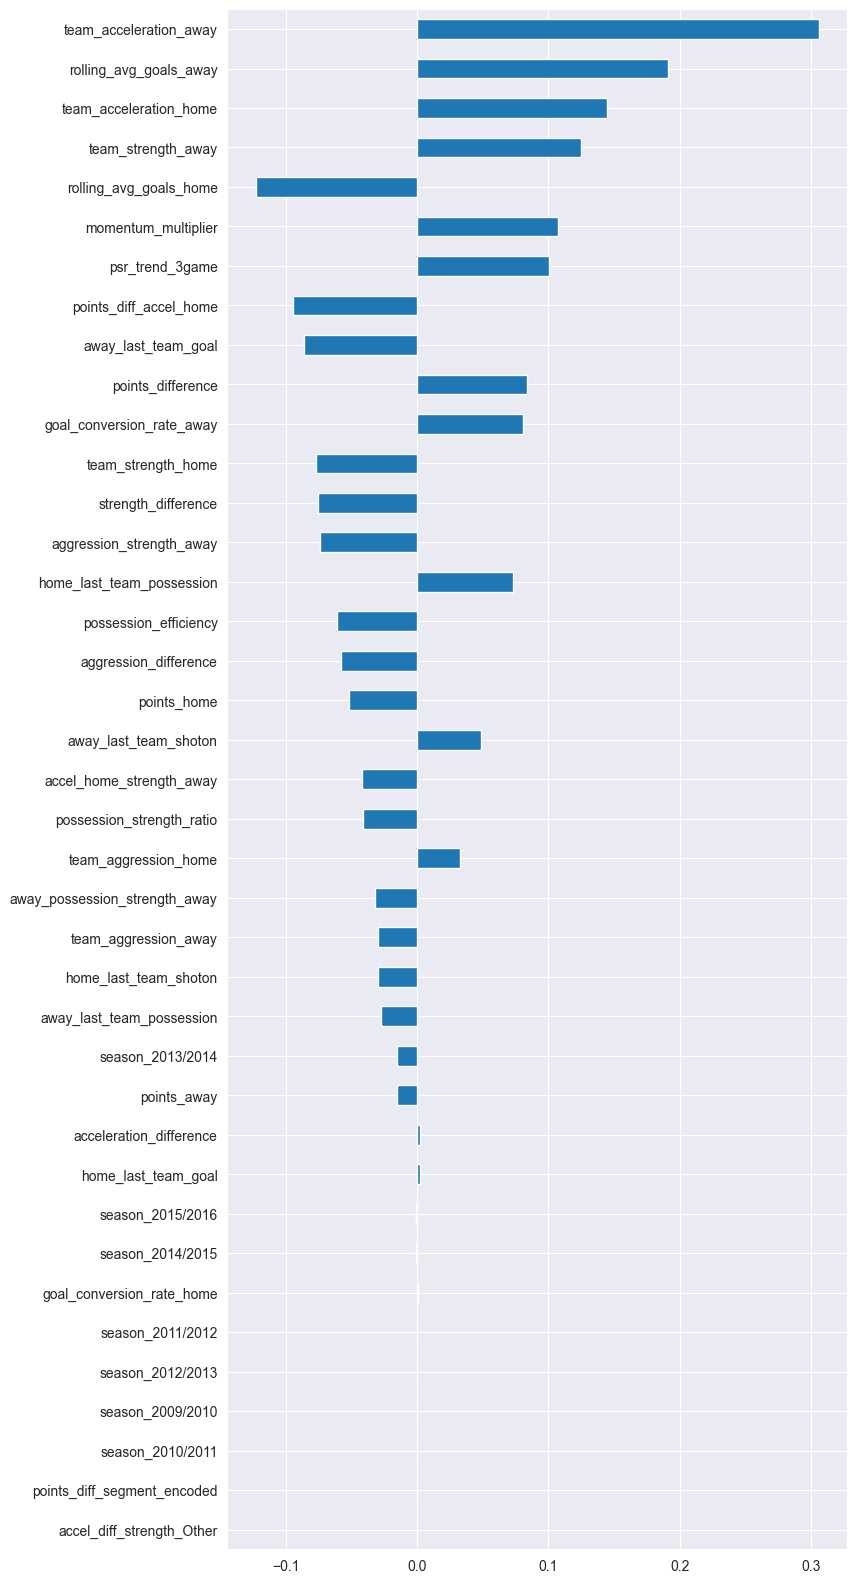

In [81]:
fig, ax = plt.subplots(figsize=(8, 20))
(pd.Series(vals.values[4], index=X_tst.columns)
 .sort_values(key=np.abs)
 .plot.barh(ax=ax)
 )
plt.show()

In [11]:
target_values_count = y_trn.value_counts()

In [12]:
ratio = target_values_count[0] / target_values_count[1]

np.int64(908)

In [13]:
target_values_count[1]

np.int64(731)